# Comparing uninformative prior with mixture and non-mixture models

In [1]:
import os
import json
import tqdm
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from llm_elicited_priors.plotting import graph_theme
from llm_elicited_priors.utils import load_nested_dict_to_pandas

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [2]:
width = 7.1413/0.75
colwidth = 3.433071
linewidth = 7.12598

In [3]:
RESULTS_PATH = Path(os.path.join("results", "elicitation"))

In [4]:
number_of_labels_to_plot = [5, 10, 20, 30, 40, 50]

Loading results

In [5]:
def load_result_dicts(path: Path):
    results_files = [
        f for f in os.listdir(path) 
        if (f.endswith(".json") and f.startswith("prior_no_prior"))
    ]
    print(f"Loading {len(results_files)} files from {path}")
    results_dicts = [
        json.load(open(os.path.join(path, f), "r"))
        for f in results_files
    ]

    return results_files, results_dicts

In [6]:
def result_dicts_to_df(results_files, results_dicts):
    results_dfs = [
        load_nested_dict_to_pandas(
            results_dict, level_names=["dataset", "run", "n_data_points_seen", "prior_type"]
        ).assign(results_file_name=results_file_name)
        
        for results_dict, results_file_name in zip(results_dicts, results_files)
    ]

    results_df = pd.concat(
        results_dfs
    ).astype(
        {
            "n_data_points_seen": int,
        }
    )

    return results_df

In [7]:
# results directory for each model
model_results_dir_dict = {
    "gpt_prior": "gpt-3-5-turbo-0125",
    "uninformative": "uninformative",
    "uninformative-100": "uninformative-100",
    "uninformative-100-gaussian_means": "uninformative-100-gaussian_means",
    "deepseek_32b_q4": "deepseek-r1-32b-int4",
}

results_df = pd.DataFrame()

for model_name, model_results_dir in tqdm.tqdm(
    model_results_dir_dict.items(), desc="Loading results"
):
    results_df = pd.concat(
        [
            results_df,
            # loading the results from the dictionaries to a dataframe
            result_dicts_to_df(
                # loading the files to dictionaries
                *load_result_dicts(RESULTS_PATH.joinpath(model_results_dir))
            ).replace(
                # adding the model name
                {"prior_type": {"informative": model_name}}
            )
        ]
    )

Loading results:   0%|          | 0/5 [00:00<?, ?it/s]

Loading 80 files from results/elicitation/gpt-3-5-turbo-0125


Loading results:  20%|██        | 1/5 [00:02<00:10,  2.65s/it]

Loading 80 files from results/elicitation/uninformative


Loading results:  40%|████      | 2/5 [00:05<00:07,  2.65s/it]

Loading 60 files from results/elicitation/uninformative-100


Loading results:  60%|██████    | 3/5 [00:07<00:05,  2.57s/it]

Loading 60 files from results/elicitation/uninformative-100-gaussian_means


Loading results:  80%|████████  | 4/5 [00:10<00:02,  2.52s/it]

Loading 60 files from results/elicitation/deepseek-r1-32b-int4


Loading results: 100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


Processing the results

In [8]:
dataset_metric_to_plot = {
    "fake_data": "mse",
    "uti": "accuracy",
    "breast_cancer": "accuracy",
    "california_housing": "mse",
    "heart_disease": "accuracy",
    "wine_quality": "accuracy",
    "diabetes": "mse",
    "hypothyroid": "accuracy",

}
dataset_rename = {
    "fake_data": r"$y = 2 x_1 - x_2 + x_3$",
    "uti": "UTI",
    "breast_cancer": "Breast Cancer",
    "california_housing": "California Housing",
    "heart_disease": "Heart Disease",
    "wine_quality": "Wine Quality",
    "diabetes": "Diabetes",
    "hypothyroid": "Hypothyroid",
}

accuracy_results_line_plot = (
    results_df
    # get the correct metric for each dataset
    .assign(
        metrics_to_plot=lambda df: (
            df.apply(
                lambda row: row[dataset_metric_to_plot[row["dataset"]]],
                axis=1
            )
        )
    )
    .assign(
        metrics_to_plot=lambda x: x["metrics_to_plot"].apply(
            lambda x: np.array(x).reshape(-1)),
    )
    .set_index(["dataset", "n_data_points_seen", "prior_type", "run"])
    [["metrics_to_plot"]]
    .reset_index()
    .reset_index(drop=True)
    .replace({"dataset": dataset_rename})
    .loc[lambda df: df["n_data_points_seen"].isin(number_of_labels_to_plot)]
    .assign(metrics_to_plot=lambda x: x["metrics_to_plot"].apply(lambda x: x.mean()))
)
accuracy_results_line_plot

,dataset,n_data_points_seen,prior_type,run,metrics_to_plot
1,UTI,5,gpt_prior,9,0.636044
2,UTI,10,gpt_prior,9,0.669356
3,UTI,20,gpt_prior,9,0.685267
4,UTI,30,gpt_prior,9,0.699686
5,UTI,40,gpt_prior,9,0.672321
...,...,...,...,...,...
2375,Hypothyroid,10,deepseek_32b_q4,8,0.799383
2376,Hypothyroid,20,deepseek_32b_q4,8,0.877892
2377,Hypothyroid,30,deepseek_32b_q4,8,0.875347
2378,Hypothyroid,40,deepseek_32b_q4,8,0.906733


In [9]:
method_names = {
    "gpt_prior": r"GPT-3.5-turbo prior", 
    "uninformative": "Previous uninformative prior", 
    "uninformative-100": "Uninformative mixture prior", 
    "uninformative-100-gaussian_means": "Uninformative mixture prior with Gaussian means",
    "deepseek_32b_q4": r"DeepSeek-R1-32B-Q4 prior",

}

palette = {
    method_names["uninformative"]: "xkcd:bright orange",
    method_names["gpt_prior"]: "xkcd:bright blue",
    method_names["uninformative-100"]: "xkcd:bright blue",
    method_names["uninformative-100-gaussian_means"]: "xkcd:purple",
    method_names["deepseek_32b_q4"]: "xkcd:kelly green",
}

markers = {
    method_names["uninformative"]: "o",
    method_names["gpt_prior"]: "X",
    method_names["uninformative-100"]: "X",
    method_names["uninformative-100-gaussian_means"]: "s",
    method_names["deepseek_32b_q4"]: "s",
}

dashes = {
    method_names["uninformative"]: (3, 1), 
    method_names["gpt_prior"]: (1, 0),
    method_names["uninformative-100"]: (2, 1), 
    method_names["uninformative-100-gaussian_means"]: (4, 1), 
    method_names["deepseek_32b_q4"]: (1, 0),

}


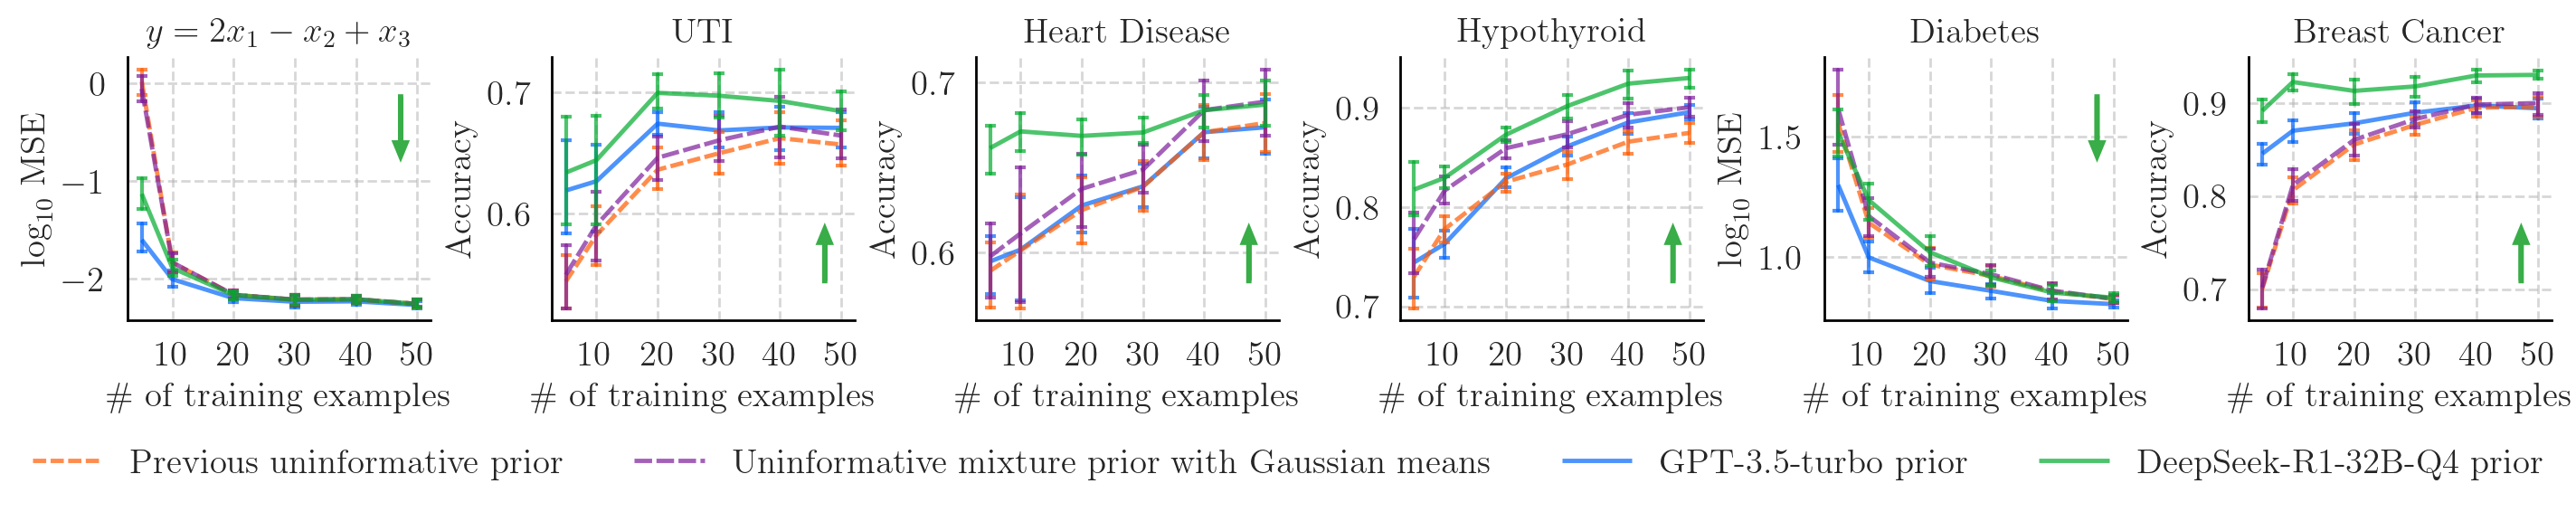

In [10]:
methods_to_plot = [
    "uninformative",
    #"uninformative-100",
    "uninformative-100-gaussian_means",
    "gpt_prior",
    "deepseek_32b_q4",
]

fontsize = 14

linewidth_on_plot = 1.75
alpha = 0.7

datasets_to_plot = [
    r"$y = 2 x_1 - x_2 + x_3$",
    "UTI",
    "Heart Disease",
    "Hypothyroid",
    "Diabetes",
    "Breast Cancer",
    #"California Housing",
    #"Wine Quality",
]

with graph_theme():
    plt.close()

    fig, axes = plt.subplots(
        1, len(datasets_to_plot), 
        figsize=(2*linewidth, 0.6*linewidth/1.618)
    )

    for nax, (dataset, ax) in enumerate(
        zip(
            datasets_to_plot,
            axes
        )
    ):

        ax = sns.lineplot(
            data=(
                accuracy_results_line_plot
                .loc[lambda df: df["prior_type"].isin(methods_to_plot)]
                .query("dataset == @dataset")
                .replace({"prior_type": method_names})
                .assign(
                    metrics_to_plot=lambda x: 
                    np.log10(x["metrics_to_plot"].astype(float)) 
                    if dataset in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"]
                    else x["metrics_to_plot"]
                )
            ),
            x="n_data_points_seen",
            y="metrics_to_plot",
            hue="prior_type",
            palette=palette,
            style="prior_type",
            style_order=[
                method_names[m_name]
                for m_name in methods_to_plot
            ],
            alpha=alpha,
            dashes=dashes,
            err_style="bars",
            errorbar=("ci", 95),
            err_kws=dict(
                capsize=2,
                capthick=1.5,
                elinewidth=1.5,
                linewidth=1.5,
            ),
            markersize=6,
            linewidth=linewidth_on_plot,
            ax=ax,
            legend=False
        )

        if nax == 0:
            if dataset in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"]:
                ax.set_ylabel(r"$\log_{10}$ MSE", fontsize=fontsize)
            else:
                ax.set_ylabel("Accuracy", fontsize=fontsize)
        else:
            if dataset in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"]:
                ax.set_ylabel(r"$\log_{10}$ MSE", fontsize=fontsize)
            else:
                ax.set_ylabel("Accuracy", fontsize=fontsize)
        ax.set_xlabel("\# of training examples", fontsize=fontsize)
        ax.tick_params(axis="both", labelsize=fontsize)
        ax.set_title(dataset, fontsize=fontsize)
        ax.set_xticks(np.arange(0, 51, 10))

        y = (
            0.15 
            if dataset not in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"] 
            else 0.85
        )
        dy = (
            0.075*(0.8/0.3)*(1.4/1.6)*5/6
            if dataset not in ["California Housing", r"$y = 2 x_1 - x_2 + x_3$", "Diabetes"] 
            else -0.075*(0.8/0.3)*(1.4/1.6)
        )
        ax.arrow(
            x=0.9, y=y, 
            dx=0.0, dy=dy,
            head_width=0.05/(1.25*1.33)*6/5, 
            head_length=0.025*(1.25*1.33)*(0.5/0.3)*(1.4/1.6)*5/6,
            color='xkcd:medium green',
            alpha=1.0,
            linewidth=2,
            transform=ax.transAxes
        )


    leg = fig.legend(
        loc="lower center",
        labels=[
            method_names[m_name] for m_name in methods_to_plot
        ], 
        handles=[
            plt.Line2D(
                [0,1], [0,1], 
                color=palette[method_names[m_name]], 
                markerfacecolor=palette[method_names[m_name]], 
                markeredgecolor="white",
                markersize=6,
                linewidth=linewidth_on_plot,
                linestyle=(0, dashes[method_names[m_name]]),
                alpha=alpha,
            )
            for m_name in methods_to_plot
        ],
        fontsize=fontsize,
        title_fontsize=fontsize,
        bbox_to_anchor=(0.5, -0.05),
        ncols=5,
        frameon=False,
    )

    fig.subplots_adjust(
        wspace=0.4,
        left=0.05,
        right=0.99,
        top=0.9,
        bottom=0.35,
    )

    fig.savefig("results/elicitation_results_lineplot_comparing_uninformative.pdf")
    fig.savefig("results/elicitation_results_lineplot_comparing_uninformative.svg")
    fig.savefig("results/elicitation_results_lineplot_comparing_uninformative.png", dpi=400)

    plt.show()